In [216]:
import os
import re
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from plotly import graph_objects as go
from matplotlib import pyplot as plt
from typing import Union, Optional
from src.utils import fetch_data
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,f1_score, roc_auc_score,
    confusion_matrix, cohen_kappa_score, auc, roc_curve, precision_recall_curve
    )

## Functions

### 1. Load Models
This function is to design for the `loading different model` form the model folder in the project.

In [2]:
def load_models(model_type: str):
    BASE_PATH = os.getcwd()
    MAIN_MODLES_PATH = os.path.join(BASE_PATH, 'models')
    MODELS_DIR = [d for d in os.listdir(MAIN_MODLES_PATH) if os.path.isdir(os.path.join(MAIN_MODLES_PATH, d))]
    models_dict = {}
    for d in MODELS_DIR:
        MODELS_DIR_ = os.path.join(MAIN_MODLES_PATH, d)
        SUB_MODEL_DIR = os.listdir(MODELS_DIR_)
        for sub_d in SUB_MODEL_DIR:
            SUB_MODEL_DIR_ = os.path.join(MODELS_DIR_, sub_d)
            TYPE_MODEL = os.listdir(SUB_MODEL_DIR_)
            TYPE_MODEL = [tm for tm in TYPE_MODEL if tm.endswith('.pkl')]
            # print(TYPE_MODEL)
            for t in TYPE_MODEL:
                if re.search(model_type, t):
                    TYPE_MODEL_ = os.path.join(SUB_MODEL_DIR_, t)
                    key = TYPE_MODEL_.split('\\')[-2]
                    with open(TYPE_MODEL_, 'rb') as f:
                        models_dict[key] = joblib.load(f)
    return models_dict

### 2. Model Scores
This function this dedicated for to taking different models and then `calculating their scores`.

In [3]:
def score_models(
    X: Union[pd.DataFrame, np.ndarray],
    y: Union[pd.DataFrame, pd.Series, np.ndarray],
    model_dist: dict,
    model_names: list,
    metrics: dict
    ) -> dict:
    featured_training_scores = {
        model_name : {} for model_name in model_names 
    }

    for model in featured_training_scores.keys():
        for score_name, score_func in metrics.items():
            if score_name == 'roc_auc':
                featured_training_scores[model][score_name] = score_func(
                    y,
                    model_dist[model].predict_proba(X)[:, 1]
                    )
            else:
                featured_training_scores[model][score_name] = score_func(
                    y,
                    model_dist[model].predict(X)
                    )
    return featured_training_scores

### 3. Format Scores
Thay function is use to format the scores that to represent it as a summary.

In [4]:
def format_scores(training_scores, testing_scores):
    # List to store the formatted data
    data = []

    # Loop through each model in the training scores
    for model_name in training_scores.keys():
        # Format the model name for better readability
        model_name_formatted = model_name.replace('_', ' ').title()
        
        # Get training and test scores for the current model
        train_scores = training_scores[model_name]
        test_scores = testing_scores[model_name]
        
        # Append the scores to the data list
        data.append([
            model_name_formatted,
            f"{train_scores['accuracy']:.2f} / {test_scores['accuracy']:.2f}",  # Accuracy
            f"{train_scores['balanced_accuracy']:.2f} / {test_scores['balanced_accuracy']:.2f}",  # Balanced Accuracy
            f"{train_scores['precision']:.2f} / {test_scores['precision']:.2f}",  # Precision
            f"{train_scores['recall']:.2f} / {test_scores['recall']:.2f}",  # Recall
            f"{train_scores['f1']:.2f} / {test_scores['f1']:.2f}",  # F1-Score
            f"{train_scores['roc_auc']:.2f} / {test_scores['roc_auc']:.2f}",  # ROC-AUC
            f"{train_scores['cohen_kappa_score']:.2f} / {test_scores['cohen_kappa_score']:.2f}",  # Cohen Kappa
        ])

    # Create a DataFrame
    columns = [
        'Model',
        'Accuracy (Train/Test)',
        'Balanced Accuracy (Train/Test)',
        'Precision (Train/Test)',
        'Recall (Train/Test)',
        'F1-Score (Train/Test)',
        'ROC-AUC (Train/Test)',
        'Cohen Kappa (Train/Test)',
    ]

    featured_training_scores_df = pd.DataFrame(data, columns=columns)

    # Display the DataFrame
    featured_training_scores_df.set_index('Model', inplace=True)
    return featured_training_scores_df

### 4. Transform to DF
It will transform nested dictionary into pandas DataFrame.

In [5]:
def transform_to_df(dictionary, score_type):
    data = []
    for model_name, scores in dictionary.items():
        model_name_formatted = model_name.replace('_', ' ').title()
        for metric, value in scores.items():
            data.append([model_name_formatted, metric, value, score_type])
    return pd.DataFrame(data, columns=['Model', 'Metric', 'Value', 'Score Type'])

### 5. Plot Comparison

In [20]:
def plot_comparison(df1, df2, title, colormap:str = 'coolwarm'):
    # Extract unique metrics and models
    metrics = df1['Metric'].unique()
    models = df1['Model'].unique()
    
    # Number of metrics and models
    n_metrics = len(metrics)
    n_models = len(models)
    
    # Bar width and spacing
    bar_width = 0.35 / n_models  # Adjust width based on number of models
    indices = np.arange(n_metrics)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Set light bachgroung color
    fig.patch.set_facecolor('#f7f7f7')
    ax.set_facecolor(color='#ffffff')
    
    # Define a color palette
    # colors = plt.cm.viridis(np.linspace(0, 1, n_models))
    colors = plt.cm.get_cmap(colormap)(np.linspace(0, 1, n_models + 6))
    
    # Plot bars for each model
    for i, model in enumerate(models):
        # Filter data for the current model
        train_data = df1[df1['Model'] == model]
        test_data = df2[df2['Model'] == model]
        
        # Calculate positions
        train_positions = indices + i * bar_width * 2 - (n_models * bar_width)
        test_positions = train_positions + bar_width

    
        # Training scores
        train_bars = ax.bar(
            train_positions,  # Position bars for each model
            # indices + i * bar_width,
            train_data['Value'],
            width=bar_width,
            color=colors[i + 1],
            edgecolor='black',
            linewidth=1,
            # label=f'{model} - Train',
            alpha=0.7
        )
        
        # Testing scores
        test_bars = ax.bar(
            test_positions,  # Position bars for each model
            # indices + i * bar_width + bar_width/2,
            test_data['Value'],
            width=bar_width,
            color=colors[i + 1],
            edgecolor='black',
            linewidth=1,
            # label=f'{model} - Test',
            alpha=0.7
        )
        
        for bar, model, value in zip(train_bars, train_data['Model'], train_data['Value']):
            height = bar.get_height()
            ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            height / 2,  # Y position (middle of the bar)
            f'{model} - Train: {value:.2f}',  # Text to display
            ha='center',  # Horizontal alignment
            va='center',  # Vertical alignment
            color='black',
            fontsize=10,
            rotation=90
        )
        
        for bar, model, value in zip(test_bars, test_data['Model'], test_data['Value']):
            height = bar.get_height()
            ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            height / 2,  # Y position (middle of the bar)
            f'{model} - Test: {value:.2f}',  # Text to display
            ha='center',  # Horizontal alignment
            va='center',  # Vertical alignment
            color='black',
            fontsize=10,
            rotation=90
        )
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add labels, title, and legend
    ax.set_xticks(indices)
    ax.set_xticklabels(
        [m.replace('_', ' ').title() for m in metrics.tolist()],
        fontsize=12
        )
    
    # Add labels, title, and legend
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Metric', fontsize=14, labelpad=10)
    plt.ylabel('Score', fontsize=14, labelpad=10)
    
    # Add a legend
    # plt.legend(title='Model - Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

### 6. Plot ROC Curve

In [215]:
def plot_roc(model_names, models_matrix_curve, title, x_title, y_title):
    fig = go.Figure()

    for name, model in zip(model_names, models_matrix_curve.values()):
        m1, m2 = model[0], model[1]
        roc_auc = auc(m1, m2)
        
        fig.add_trace(
            go.Scatter(
                x=m1,
                y=m2,
                mode='lines',
                name=f'{name} (AUC = {roc_auc:.2f})',
                line=dict(width=2),
                hovertemplate='FPR: %{x:.3f}<br>TPR: %{y:.3f}<extra></extra>'
            )
        )

    fig.add_trace(
        go.Scatter(
            x=[0, 1],
            y=[0, 1],
            mode='lines',
            name='Random Guessing (AUC = 0.50)',
            line=dict(color='gray', dash='dash'),
            hovertemplate='FPR: %{x:.3f}<br>TPR: %{y:.3f}<extra></extra>'
        )
    )

    fig.update_layout(
        title=title,
        title_font=dict(size=24, family='Arial', color='black'),
        title_x=0.5,
        xaxis=dict(
            title=x_title,
            title_font=dict(size=18, family='Arial', color='black'),
            tickfont=dict(size=14, family='Arial', color='black'),
            range=[0, 1],
            dtick=0.1,
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title=y_title,
            title_font=dict(size=18, family='Arial', color='black'),
            tickfont=dict(size=14, family='Arial', color='black'),
            range=[0, 1],
            dtick=0.1,
            gridcolor='lightgray'
        ),
        legend=dict(
            title='Model',
            title_font=dict(size=16, family='Arial', color='black'),
            x=1.05,
            y=1,
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='gray'
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=900,
        height=500,
        margin=dict(l=80, r=80, t=80, b=80)
    )

    fig.show()

### 7. Plot Confusion Matrix

In [350]:
def plot_cm(models_name, models_cm, title):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (11,9))
    ax = ax.flatten()
    class_name = ['Less than $50k', 'Geater than $50k']
    for i, (model_name, cm) in enumerate(zip(models_name, models_cm.values())):
        sns.heatmap(
            data=cm,
            annot=True,
            fmt='d',
            xticklabels=class_name,
            yticklabels=class_name,
            ax=ax[i],
            cmap='Blues',
            annot_kws={'fontsize': 14, 'fontname': 'Arial'}
        )
        title = re.sub('(_featured_set|_simple_featured_set)', '', model_name).replace('_', ' ').title()
        ax[i].set_title(title, fontsize=16, color='royalblue', loc='center', pad=10, fontname='Comic Sans MS')
        ax[i].set_xlabel('Predicted Labels', fontsize=12, color='black', labelpad=10, fontname='Comic Sans MS')
        ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12, color='#222223', rotation=0, fontname='Verdana')
        ax[i].set_yticklabels(ax[i].get_xticklabels(), fontsize=12, color='#222223', rotation=90, fontname='Verdana')
        ax[i].set_ylabel('Actual Labels', fontsize=12, color='black', labelpad=10, fontname='Comic Sans MS')

    for j in range(i + 1, len(ax)):
        ax[j].axis('off')

    # ax[3].set_position([0.35, 0.1, 0.3, 0.4])

    fig.suptitle('Confusion Matrix (Featured Set)', fontsize=20, fontweight='bold', color='darkblue', fontname='Verdana', y=1.02)
    plt.tight_layout()
    plt.show()

## Extract Data From  the Sourse

In [6]:
X_train_transformed = fetch_data(FILE_NAME='X_train_transformed.csv', DIRECTORY_NAME='featured')
X_test_transformed = fetch_data(FILE_NAME='X_test_transformed.csv', DIRECTORY_NAME='featured')


X_train_simple_transformed = fetch_data(FILE_NAME='X_train_simple_transformed.csv', DIRECTORY_NAME='processed')
X_test_simple_transformed = fetch_data(FILE_NAME='X_test_simple_transformed.csv', DIRECTORY_NAME='processed')

y_train = fetch_data(FILE_NAME='y_train_transformed.csv', DIRECTORY_NAME='processed')
y_test = fetch_data(FILE_NAME='y_test_transformed.csv', DIRECTORY_NAME='processed')

## Extract Models & Scores
Here we extract different models including `Baseline` and `Tuned` based on classification problem, and which had been trained on different training datasets that includes `simple featured set` and `newly extracted featured set`.

### 1. Fetch Baseline Models

In [45]:
# ***** Unfortunately some baseline models are currrently not working due to Unmatch of SK-learn version *****
baseline_model_dict = load_models('tuned')

### 2. Fetch Tuned Models

In [7]:
model_dict = load_models('tuned')

#### 1. Compute Scores on Training and Test Set

In [8]:
# Defining the keys based on the dataset
simple_featured_key = [featured_set for featured_set in list(model_dict.keys()) if re.search(r'simple', featured_set)]
featured_key = [featured_set for featured_set in list(model_dict.keys()) if not re.search(r'simple', featured_set)]

# Defining the metrics for the model
score_names = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cohen_kappa_score']
score_funcs = [accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score]
metrics = {score_name: score_func for score_name, score_func in zip(score_names, score_funcs)}


##### 1. Compute Training Scores

In [9]:
featured_training_scores = score_models(
    X=X_train_transformed,
    y=y_train,
    model_dist=model_dict,
    model_names=featured_key,
    metrics=metrics
)

In [10]:
simple_featured_training_scores = score_models(
    X=X_train_simple_transformed,
    y=y_train,
    model_dist=model_dict,
    model_names=simple_featured_key,
    metrics=metrics
)

##### 2. Compute Test Scores

In [11]:
featured_test_scores = score_models(
    X=X_test_transformed,
    y=y_test,
    model_dist=model_dict,
    model_names=featured_key,
    metrics=metrics
)

In [12]:
simple_featured_test_scores = score_models(
    X=X_test_simple_transformed,
    y=y_test,
    model_dist=model_dict,
    model_names=simple_featured_key,
    metrics=metrics
)

## Compare Model Using Performance Metrics
We have start by comparing the models across the metrics that we have already computed:
- Accuracy
- Balanced Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC
- Cohen Kappa

### 1. Summary Table

#### 1. Model Scores Based on Featured Set

In [13]:
featured_scores_df = format_scores(featured_training_scores, featured_test_scores)
featured_scores_df

,Accuracy (Train/Test),Balanced Accuracy (Train/Test),Precision (Train/Test),Recall (Train/Test),F1-Score (Train/Test),ROC-AUC (Train/Test),Cohen Kappa (Train/Test)
Model,,,,,,,
Logistic Regression Featured Set,0.80 / 0.81,0.81 / 0.82,0.55 / 0.57,0.84 / 0.85,0.67 / 0.68,0.90 / 0.90,0.53 / 0.55
Random Forest Featured Set,0.89 / 0.87,0.81 / 0.78,0.84 / 0.79,0.66 / 0.62,0.74 / 0.69,0.95 / 0.92,0.67 / 0.61
Xgboost Featured Set,0.89 / 0.87,0.86 / 0.83,0.76 / 0.73,0.79 / 0.76,0.78 / 0.74,0.95 / 0.93,0.70 / 0.66


#### 2. Model Scores Based on Simple Featured Set

In [14]:
simple_featured_scores_df = format_scores(simple_featured_training_scores, simple_featured_test_scores)
simple_featured_scores_df

,Accuracy (Train/Test),Balanced Accuracy (Train/Test),Precision (Train/Test),Recall (Train/Test),F1-Score (Train/Test),ROC-AUC (Train/Test),Cohen Kappa (Train/Test)
Model,,,,,,,
Logistic Regression Simple Featured Set,0.80 / 0.80,0.81 / 0.82,0.55 / 0.56,0.84 / 0.85,0.67 / 0.68,0.90 / 0.90,0.53 / 0.54
Random Forest Simple Featured Set,0.90 / 0.87,0.83 / 0.79,0.86 / 0.80,0.70 / 0.64,0.77 / 0.71,0.96 / 0.92,0.71 / 0.63
Xgboost Simple Featured Set,0.87 / 0.87,0.85 / 0.84,0.71 / 0.70,0.81 / 0.79,0.76 / 0.74,0.94 / 0.93,0.67 / 0.65


### 2. Visualizaing of Metrics

In [32]:
df_featured_train = transform_to_df(featured_training_scores, 'Training')
df_featured_test = transform_to_df(featured_test_scores, 'Testing')
df_simple_featured_train = transform_to_df(simple_featured_training_scores, 'Training')
df_simple_featured_test = transform_to_df(simple_featured_test_scores, 'Testing')


C:\Users\user\AppData\Local\Temp\ipykernel_14064\2291667943.py:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



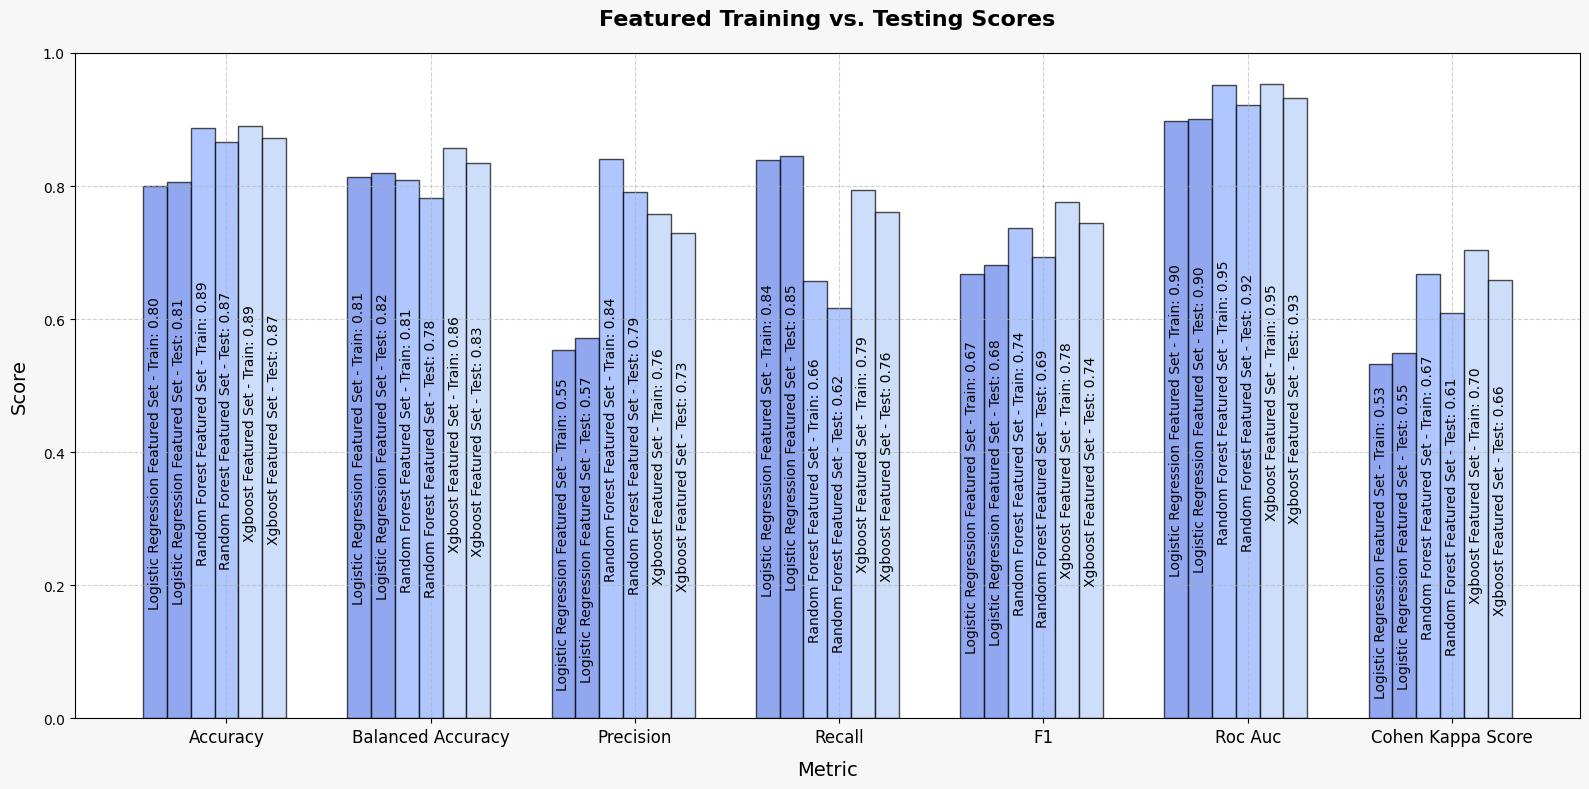

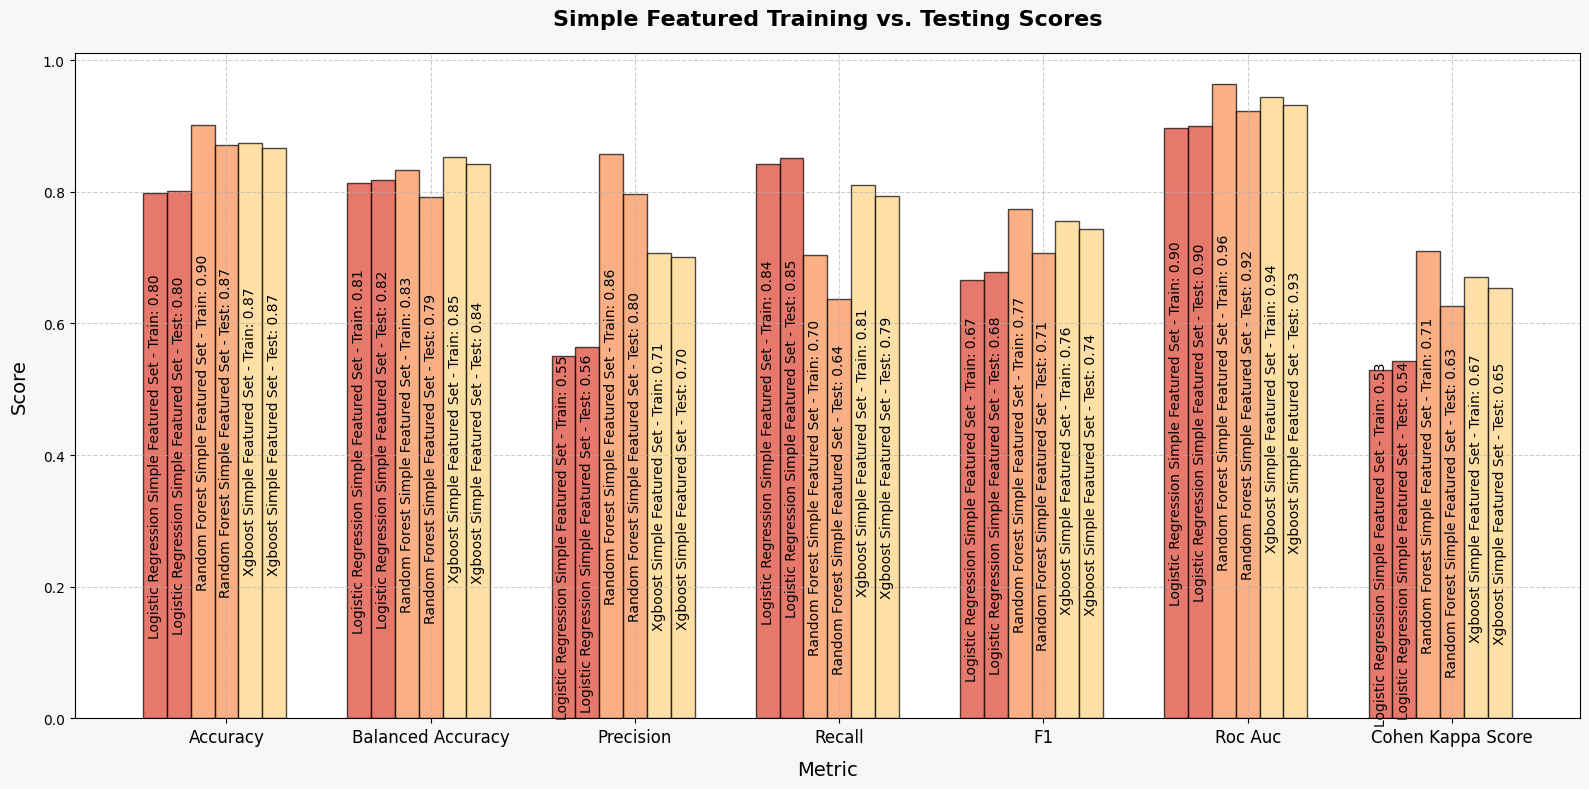

In [23]:
plot_comparison(df_featured_train, df_featured_test, 'Featured Training vs. Testing Scores', colormap='coolwarm')
plot_comparison(df_simple_featured_train, df_simple_featured_test, 'Simple Featured Training vs. Testing Scores', colormap='RdYlGn')


## Analyze Overfitting

In [ ]:
# Creating Pivot Table For Batter Representation

combined_featured_df = pd.concat([df_featured_train, df_featured_test])
featured_pivot_df = combined_featured_df.pivot_table(
    index=['Model', 'Metric'],
    columns='Score Type',
    values='Value'
    )
featured_pivot_df['Difference'] = featured_pivot_df['Training'] - featured_pivot_df['Testing']
featured_pivot_df = featured_pivot_df[['Training', 'Testing', 'Difference']]

combined_simple_featured_df = pd.concat([df_simple_featured_train, df_simple_featured_test])
simple_featured_pivot_df = combined_simple_featured_df.pivot_table(
    index=['Model', 'Metric'],
    columns='Score Type',
    values='Value'
    )
simple_featured_pivot_df['Difference'] = simple_featured_pivot_df['Training'] - simple_featured_pivot_df['Testing']
simple_featured_pivot_df = simple_featured_pivot_df[['Training', 'Testing', 'Difference']]

### 1. Bar Chart Visualization

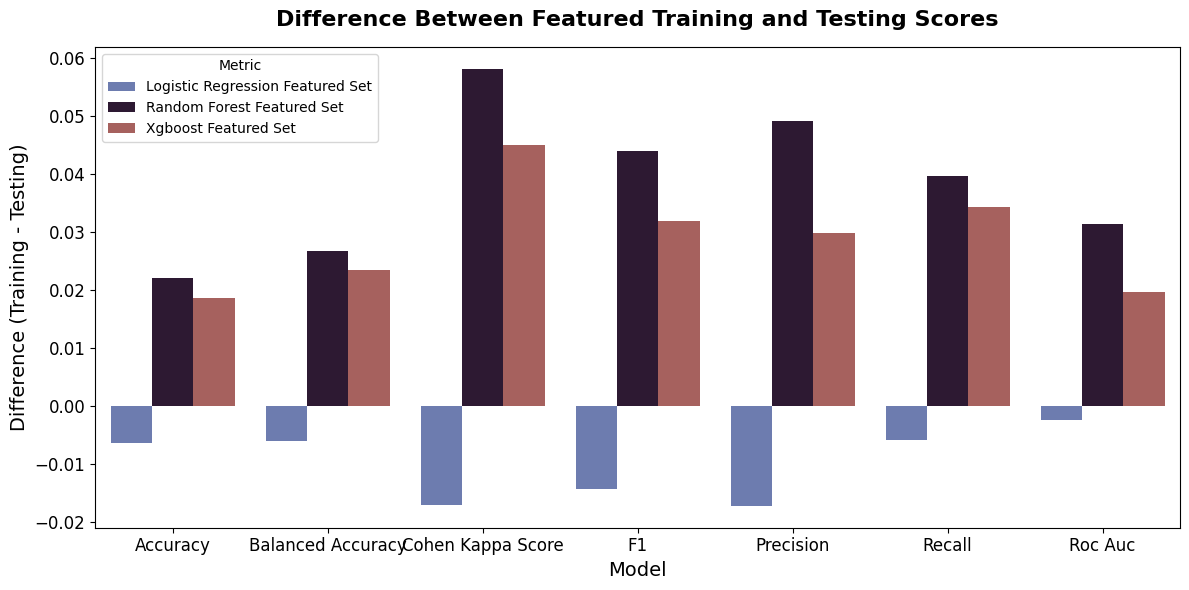

In [77]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=featured_pivot_df.reset_index(),
    x='Metric',
    y='Difference',
    hue='Model',
    palette='twilight'
)
plt.title('Difference Between Featured Training and Testing Scores', fontsize=16, fontweight='bold', pad=15)
x_ticklabels = featured_pivot_df.index.get_level_values(level='Metric').unique().tolist()
plt.xticks(
        ticks=range(len(x_ticklabels)),
        labels=[m.replace('_', ' ').title() for m in x_ticklabels],
        fontsize=12
        )
plt.yticks(fontsize=12)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Difference (Training - Testing)', fontsize=14)
# plt.xticks(rotation=45)
plt.legend(title='Metric', loc='upper left')
plt.tight_layout()
plt.show()

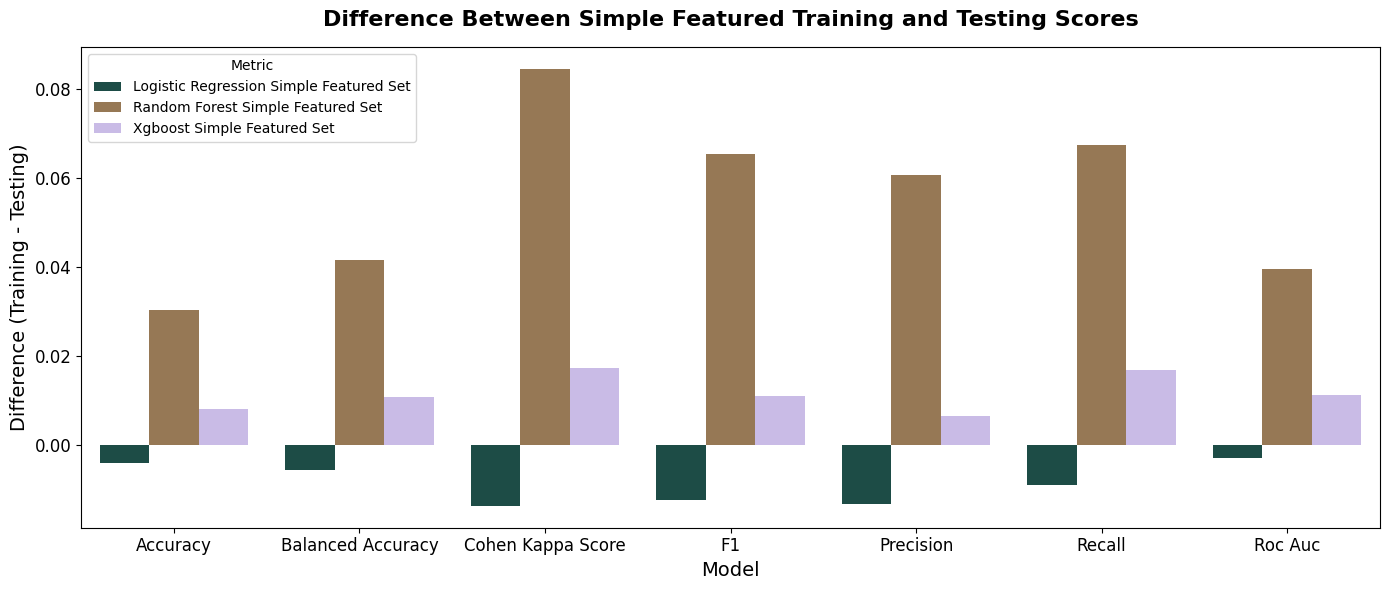

In [115]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=simple_featured_pivot_df.reset_index(),
    x='Metric',
    y='Difference',
    hue='Model',
    palette='cubehelix'
)
plt.title('Difference Between Simple Featured Training and Testing Scores', fontsize=16, fontweight='bold', pad=15)
x_ticklabels = simple_featured_pivot_df.index.get_level_values(level='Metric').unique().tolist()
plt.xticks(
        ticks=range(len(x_ticklabels)),
        labels=[m.replace('_', ' ').title() for m in x_ticklabels],
        fontsize=12
        )
plt.yticks(fontsize=12)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Difference (Training - Testing)', fontsize=14)
# plt.xticks(rotation=45)
plt.legend(title='Metric', loc='upper left')
plt.tight_layout()
plt.show()

### 2. Line Chart Visualisation

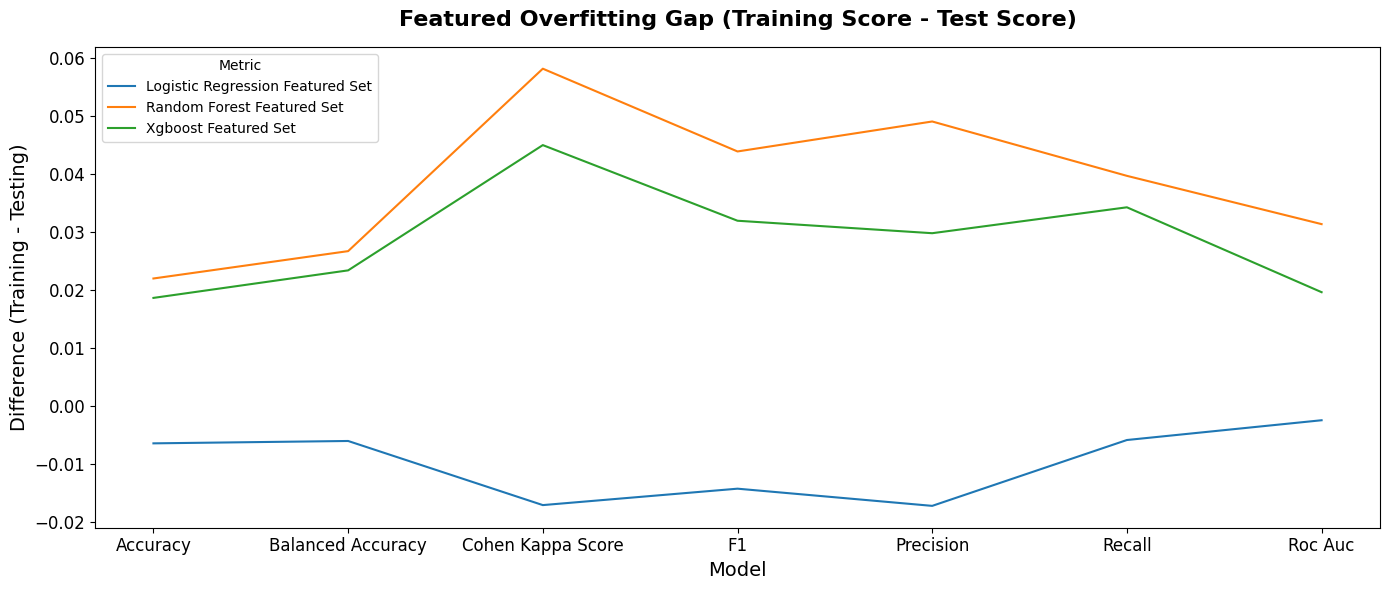

In [106]:
fig, ax = plt.subplots(figsize=(14, 6))
models = featured_pivot_df.index.get_level_values(level='Model').unique().tolist()
metrics = featured_pivot_df.index.get_level_values(level='Metric').unique().tolist()
scores = featured_pivot_df.groupby(level='Model')['Difference'].apply(list)

for i, model in enumerate(models):
    ax.plot(metrics, scores[i], label=model)

x_ticklabels = simple_featured_pivot_df.index.get_level_values(level='Metric').unique().tolist()
plt.xticks(
        ticks=range(len(x_ticklabels)),
        labels=[m.replace('_', ' ').title() for m in x_ticklabels],
        fontsize=12
        )
plt.yticks(fontsize=12)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Difference (Training - Testing)', fontsize=14)
plt.title('Featured Overfitting Gap (Training Score - Test Score)', fontsize=16, fontweight='bold', pad=15)
plt.legend(title='Metric', loc='upper left')
plt.tight_layout()
plt.show()


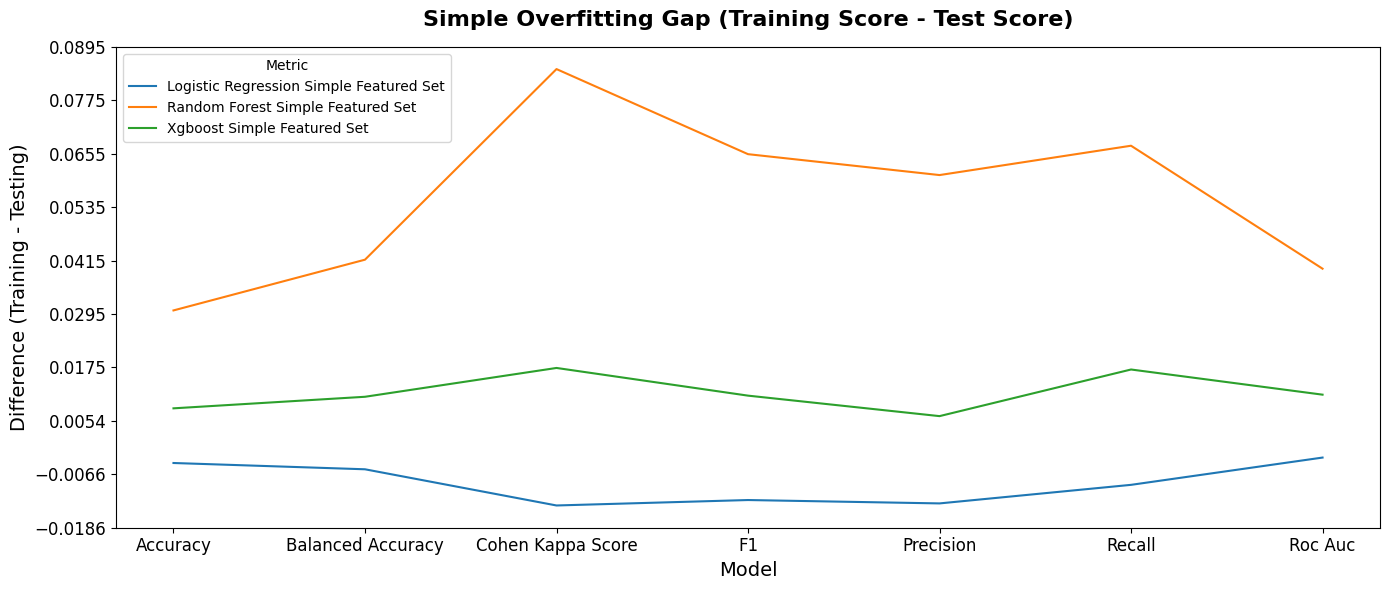

In [123]:
fig, ax = plt.subplots(figsize=(14, 6))
models = simple_featured_pivot_df.index.get_level_values(level='Model').unique().tolist()
metrics = simple_featured_pivot_df.index.get_level_values(level='Metric').unique().tolist()
scores = simple_featured_pivot_df.groupby(level='Model')['Difference'].apply(list)

for i, model in enumerate(models):
    ax.plot(metrics, scores[i], label=model)

x_ticklabels = simple_featured_pivot_df.index.get_level_values(level='Metric').unique().tolist()
plt.xticks(
        ticks=range(len(x_ticklabels)),
        labels=[m.replace('_', ' ').title() for m in x_ticklabels],
        fontsize=12
        )
y_tick_min = simple_featured_pivot_df['Difference'].min() - 0.005
y_tick_max = simple_featured_pivot_df['Difference'].max() + 0.005
plt.yticks(np.linspace(y_tick_min, y_tick_max, 10), fontsize=12)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Difference (Training - Testing)', fontsize=14)
plt.title('Simple Overfitting Gap (Training Score - Test Score)', fontsize=16, fontweight='bold', pad=15)
plt.legend(title='Metric', loc='upper left')
plt.tight_layout()
plt.show()


## ROC Curve and AUC Comparison

In [201]:
# Seperating a dict of models based on featured set
simple_featured_models = {name: model for name, model in model_dict.items() if re.search('simple', name)}
featured_models = {name: model for name, model in model_dict.items() if not re.search('simple', name)}

# Then make a dict of prediction probabilities based on seperated models
featured_models_y_proba = {
    name + '_proba': model.predict_proba(X_test_transformed)[:, 1]
    for name, model in featured_models.items()
    }
simple_featured_models_y_proba = {
    name + '_proba': model.predict_proba(X_test_simple_transformed)[:, 1]
    for name, model in simple_featured_models.items()
    }

# Now find the ROC Curve which returens FPR, TPR, Threshoulds based on predicted probabilities
featured_models_roc_curve = {
    name + '_roc_curve': roc_curve(y_true=y_test, y_score=y_pred_proba)
    for name, y_pred_proba in zip(featured_models.keys(), featured_models_y_proba.values())
    }
simple_featured_models_roc_curve = {
    name + '_roc_curve': roc_curve(y_true=y_test, y_score=y_pred_proba)
    for name, y_pred_proba in zip(simple_featured_models.keys(), simple_featured_models_y_proba.values())
    }


In [196]:
plot_roc(
    featured_key,
    featured_models_roc_curve,
    title='ROC Curve (Featured)',
    x_title='False Positive Rate (FPR)',
    y_title='True Positive Rate (TPR)',
    )

In [198]:
plot_roc(
    simple_featured_key,
    simple_featured_models_roc_curve,
    title='ROC Curve (Simple Featured)',
    x_title='False Positive Rate (FPR)',
    y_title='True Positive Rate (TPR)',)

## Best Threshould
There could be bunch of ways to calculate best threshold based on the specific problems, however we have calculated the `best threshold` based on the `F1 score`. We have used the following code to calculate the best threshold:

In [203]:
# And find also a Precision Recall Curve which returns Precision, Recall, Threshoulds based on predicted probabilities
featured_models_pr_curve = {
    name + '_pr_curve': precision_recall_curve(y_true=y_test, probas_pred=y_pred_proba)
    for name, y_pred_proba in zip(featured_models.keys(), featured_models_y_proba.values())
}
simple_featured_models_pr_curve = {
    name + '_pr_curve': precision_recall_curve(y_true=y_test, probas_pred=y_pred_proba)
    for name, y_pred_proba in zip(featured_models.keys(), simple_featured_models_y_proba.values())
}

In [241]:

featured_models_best_f1_score = dict()
featured_models_best_threshould = dict()

for model_name, pr_value in zip(featured_key, featured_models_pr_curve.values()):
    precision = pr_value[0]
    recall = pr_value[1]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    featured_models_best_threshould[model_name + 'best_threshould'] = pr_value[-1][np.argmax(f1_scores)]
    featured_models_best_f1_score[model_name + 'best_f1_score'] = np.max(f1_scores)

simple_featured_models_best_f1_score = dict()
simple_featured_models_best_threshould = dict()

for model_name, pr_value in zip(simple_featured_key, simple_featured_models_pr_curve.values()):
    precision = pr_value[0]
    recall = pr_value[1]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    simple_featured_models_best_threshould[model_name + 'best_threshould'] = pr_value[-1][np.argmax(f1_scores)]
    simple_featured_models_best_f1_score[model_name + 'best_f1_score'] = np.max(f1_scores)

In [251]:
pd.DataFrame(
    data=[
        {
            'Model': model_name.replace('_', ' ').title(),
            'Best F1 Score': f1,
            'Best Threshould': thresh
        }
        for model_name, f1, thresh in zip(
            featured_key + simple_featured_key,
            list(featured_models_best_f1_score.values()) + list(simple_featured_models_best_f1_score.values()),
            list(featured_models_best_threshould.values()) + list(simple_featured_models_best_threshould.values())
        )
    ]
)

,Model,Best F1 Score,Best Threshould
0,Logistic Regression Featured Set,0.684354,0.632758
1,Random Forest Featured Set,0.724522,0.369741
2,Xgboost Featured Set,0.748451,0.512565
3,Logistic Regression Simple Featured Set,0.683821,0.542101
4,Random Forest Simple Featured Set,0.728745,0.388892
5,Xgboost Simple Featured Set,0.745298,0.505396


## Confusion Matrix

In [269]:
featured_models_cm = {
    model_name + '_cm': confusion_matrix(
        y_true=y_test,
        y_pred=(y_pred_proba > model_thresh).astype(int)
        )
    for model_name, y_pred_proba, model_thresh in zip(
        featured_key,
        featured_models_y_proba.values(),
        featured_models_best_threshould.values()
    )
 }

simple_featured_models_cm = {
    model_name + '_cm': confusion_matrix(
        y_true=y_test,
        y_pred=(y_pred_proba > model_thresh).astype(int)
        )
    for model_name, y_pred_proba, model_thresh in zip(
        simple_featured_key,
        simple_featured_models_y_proba.values(),
        simple_featured_models_best_threshould.values()
    )
 }

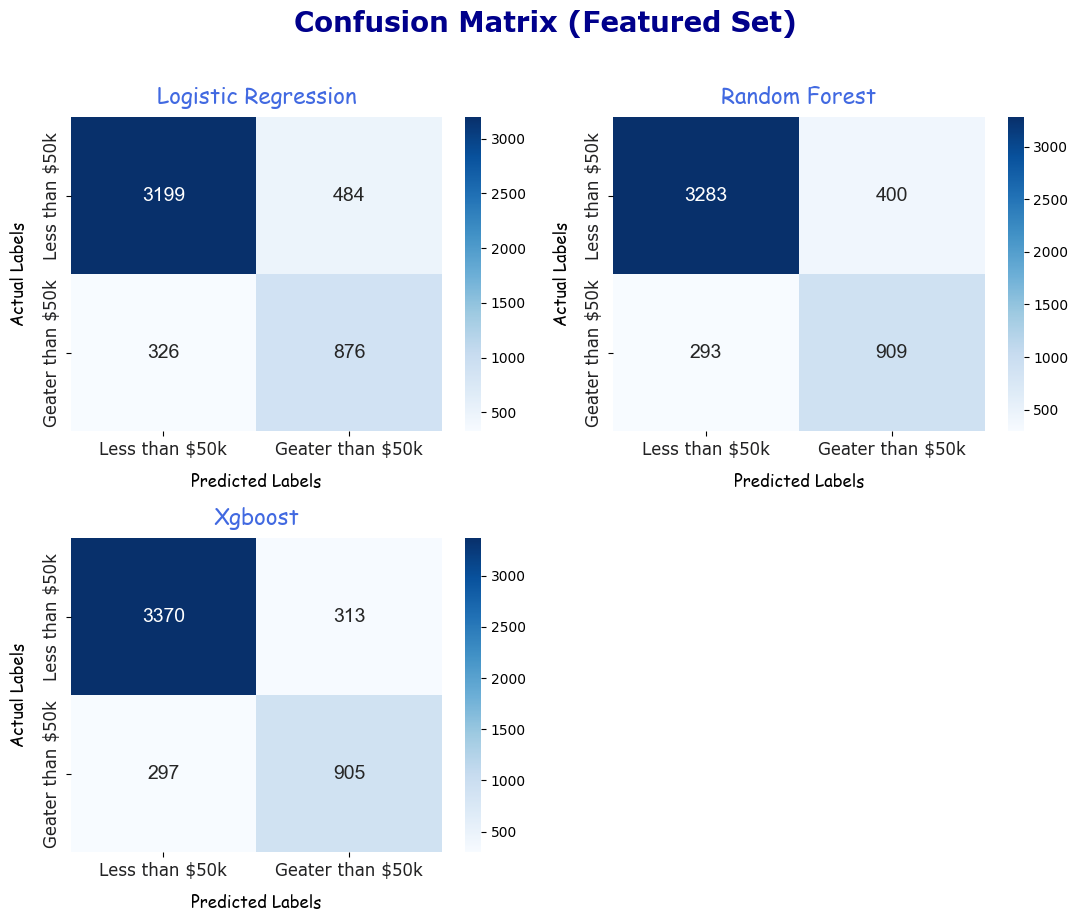

In [351]:
plot_cm(featured_key, featured_models_cm, title='Confusion Matrix (Featured Set)')

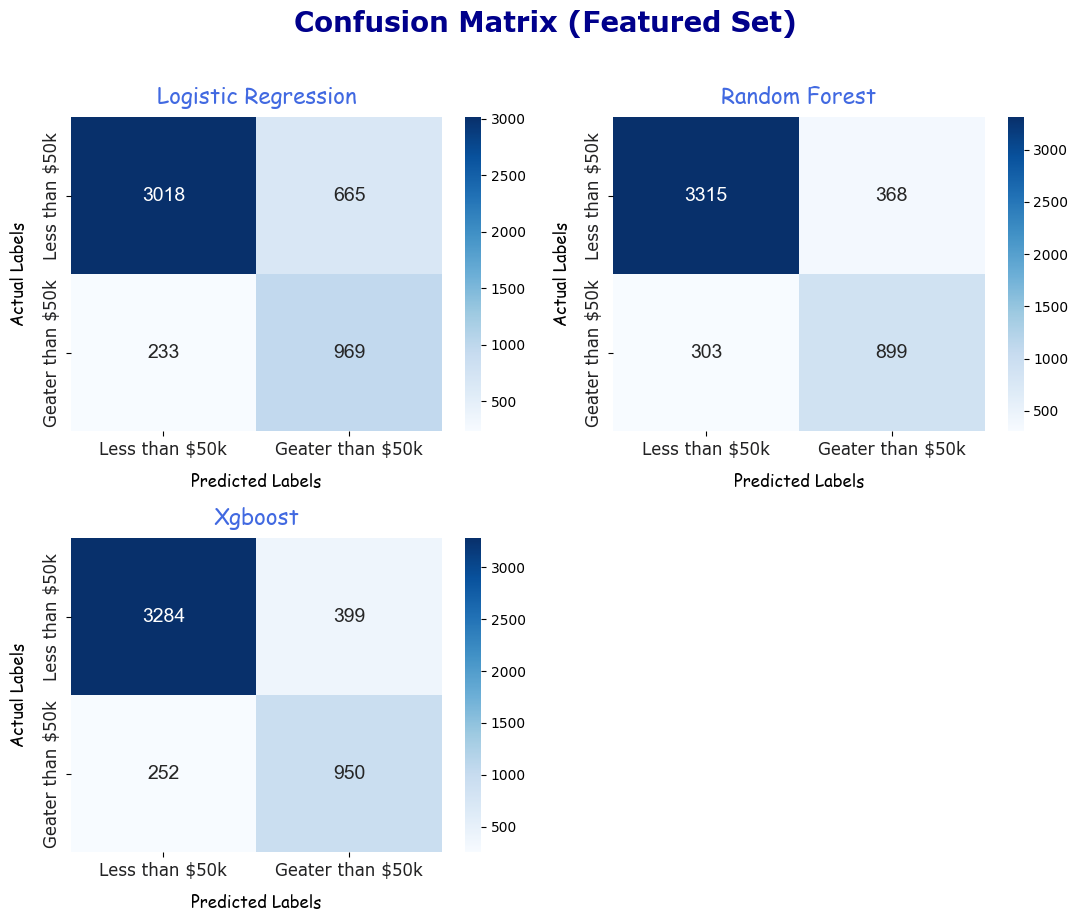

In [352]:
plot_cm(simple_featured_key, simple_featured_models_cm, title='Confusion Matrix (Simple Featured Set)')

## Depreciated Code

In [ ]:
# This code is for importing different models for further analysis
'''
BASE_PATH = os.getcwd()
MAIN_MODLES_PATH = os.path.join(BASE_PATH, 'models')
MODELS_DIR = [d for d in os.listdir(MAIN_MODLES_PATH) if os.path.isdir(os.path.join(MAIN_MODLES_PATH, d))]
baseline_models = {}
for d in MODELS_DIR:
    MODELS_DIR_ = os.path.join(MAIN_MODLES_PATH, d)
    SUB_MODEL_DIR = os.listdir(MODELS_DIR_)
    for sub_d in SUB_MODEL_DIR:
        SUB_MODEL_DIR_ = os.path.join(MODELS_DIR_, sub_d)
        TYPE_MODEL = os.listdir(SUB_MODEL_DIR_)
        TYPE_MODEL = [tm for tm in TYPE_MODEL if tm.endswith('.pkl')]
        # print(TYPE_MODEL)
        for t in TYPE_MODEL:
            if re.search(model_training_set, t):
                TYPE_MODEL_ = os.path.join(SUB_MODEL_DIR_, t)
                key = TYPE_MODEL_.split('\\')[-2]
                with open(TYPE_MODEL_, 'rb') as f:
                    baseline_models[key] = joblib.load(f)
                # print(TYPE_MODEL_.split('\\')[-2])   

temp = ['logistic_regression_baseline_p0.741342_r0.569884.pkl', 'logistic_regression_tuned_p0.571429_r0.845258.pkl']
for t in temp:
    if re.search(model_training_set, t):
        print(t) 

# Get the current working directory
current_directory = os.getcwd()

# Path to the 'models' directory
models_directory = os.path.join(current_directory, 'models')

# List all files in the 'models' directory
files_only = [f for f in os.listdir(models_directory) if os.path.isfile(os.path.join(models_directory, f))]

print("Files in 'models' directory:", files_only)
'''

# This code is use to calculate the scores of different models
'''
featured_training_scores = {
    model_name : {} for model_name in featured_key 
}

for model in featured_training_scores.keys():
    for score_name, score_func in metrics.items():
        if score_name == 'roc_auc':
            featured_training_scores[model][score_name] = score_func(
                y_train,
                model_dict[model].predict_proba(X_train_transformed)[:, 1]
                )
        else:
            featured_training_scores[model][score_name] = score_func(
                y_train,
                model_dict[model].predict(X_train_transformed)
                )
'''

# This code is to format models scores and converting then into dataframe
'''
# List to store the formatted data
data = []

# Loop through each model in the training scores
for model_name in featured_training_scores.keys():
    # Format the model name for better readability
    model_name_formatted = model_name.replace('_', ' ').title()
    
    # Get training and test scores for the current model
    train_scores = featured_training_scores[model_name]
    test_scores = featured_test_scores[model_name]
    
    # Append the scores to the data list
    data.append([
        model_name_formatted,
        f"{train_scores['accuracy']:.2f} / {test_scores['accuracy']:.2f}",  # Accuracy
        f"{train_scores['balanced_accuracy']:.2f} / {test_scores['balanced_accuracy']:.2f}",  # Balanced Accuracy
        f"{train_scores['precision']:.2f} / {test_scores['precision']:.2f}",  # Precision
        f"{train_scores['recall']:.2f} / {test_scores['recall']:.2f}",  # Recall
        f"{train_scores['f1']:.2f} / {test_scores['f1']:.2f}",  # F1-Score
        f"{train_scores['roc_auc']:.2f} / {test_scores['roc_auc']:.2f}",  # ROC-AUC
        f"{train_scores['cohen_kappa_score']:.2f} / {test_scores['cohen_kappa_score']:.2f}",  # Cohen Kappa
    ])

# Create a DataFrame
columns = [
    'Model',
    'Accuracy (Train/Test)',
    'Balanced Accuracy (Train/Test)',
    'Precision (Train/Test)',
    'Recall (Train/Test)',
    'F1-Score (Train/Test)',
    'ROC-AUC (Train/Test)',
    'Cohen Kappa (Train/Test)',
]

featured_training_scores_df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
featured_training_scores_df.set_index('Model', inplace=True)
featured_training_scores_df
'''

# This depreciated function is calculate the scores in the form of pivot table. 
'''
def transform_to_df(dictionary):
    data = []
    for model_name, scores in dictionary.items():
        matrix = []
        model_name_formatted = model_name.replace('_', ' ').title()
        for value in scores.values():
            matrix.append(value)
        data.append([model_name_formatted] + matrix)
    columns = [
    'Model',
    'Accuracy (Train/Test)',
    'Balanced Accuracy (Train/Test)',
    'Precision (Train/Test)',
    'Recall (Train/Test)',
    'F1-Score (Train/Test)',
    'ROC-AUC (Train/Test)',
    'Cohen Kappa (Train/Test)',
]
    return pd.DataFrame(data, columns=columns)
'''

# This is a fully functional function to plot the scores of different models in the form of a bar chart using seaborn.
'''
def plot_comparison_seaborn(df1, df2, title):
    # Combine the two DataFrames
    df1['Dataset'] = 'Train'
    df2['Dataset'] = 'Test'
    combined_df = pd.concat([df1, df2])
    
    # Create a new column that combines 'Model' and 'Dataset'
    combined_df['Model_Dataset'] = combined_df['Model'] + ' - ' + combined_df['Dataset']
    
    # Create the plot
    plt.figure(figsize=(16, 8))
    
    # Use Seaborn's barplot
    sns.barplot(
        data=combined_df,
        x='Metric',
        y='Value',
        hue='Model_Dataset',
        palette='viridis',  # Use a color palette
        alpha=0.7
    )
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Add labels and title
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Metric', fontsize=14, labelpad=10)
    plt.ylabel('Score', fontsize=14, labelpad=10)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, fontsize=12)
    
    # Add a legend
    plt.legend(title='Model - Dataset', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

'''

# This is a fully functional function to plot the scores of different models in the form of a bar chart using plotpy.
'''
import plotly.express as px
import pandas as pd

def plot_comparison_plotly(df1, df2, title):
    # Combine the two DataFrames
    df1['Dataset'] = 'Train'
    df2['Dataset'] = 'Test'
    combined_df = pd.concat([df1, df2])
    
    # Create the plot
    fig = px.bar(
        combined_df,
        x='Metric',
        y='Value',
        color='Model',
        barmode='group',  # Group bars by model
        facet_col='Dataset',  # Separate Train and Test into subplots
        title=title,
        labels={'Value': 'Score', 'Metric': 'Metric'},
        text='Value',  # Display values on bars
        color_discrete_sequence=px.colors.qualitative.Vivid  # Use a color palette
    )
    
    # Update layout
    fig.update_traces(texttemplate='%{text:.2f}', textposition='inside')  # Format text
    fig.update_layout(
        font=dict(size=12),
        xaxis=dict(tickangle=45),
        yaxis=dict(gridcolor='lightgray'),
        plot_bgcolor='white',  # Set background color
        title_font=dict(size=20, family='Arial', color='black'),
        legend=dict(title='Model', x=1.05, y=1)  # Move legend outside
    )
    
    # Show the plot
    fig.show()
'''

# This is a fully functional function to plot the scores of different models in the form of a bar chart using matplotlib.
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_comparison_manual_(df1, df2, title, colormap:str = '#ffffff'):
    # Extract unique metrics and models
    metrics = df1['Metric'].unique()
    models = df1['Model'].unique()
    
    # Number of metrics and models
    n_metrics = len(metrics)
    n_models = len(models)
    
    # Bar width and spacing
    bar_width = 0.35 / n_models  # Adjust width based on number of models
    indices = np.arange(n_metrics)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Set light bachgroung color
    fig.patch.set_facecolor('#f7f7f7')
    ax.set_facecolor(color='#ffffff')
    
    # Define a color palette
    # colors = plt.cm.viridis(np.linspace(0, 1, n_models))
    colors = plt.cm.get_cmap(colormap)(np.linspace(0, 1, n_models + 6))
    
    # Plot bars for each model
    for i, model in enumerate(models):
        # Filter data for the current model
        train_data = df1[df1['Model'] == model]
        test_data = df2[df2['Model'] == model]
        
        # Calculate positions
        train_positions = indices + i * bar_width * 2 - (n_models * bar_width)
        test_positions = train_positions + bar_width

    
        # Training scores
        train_bars = ax.bar(
            train_positions,  # Position bars for each model
            # indices + i * bar_width,
            train_data['Value'],
            width=bar_width,
            color=colors[i + 1],
            edgecolor='black',
            linewidth=1,
            # label=f'{model} - Train',
            alpha=0.7
        )
        
        # Testing scores
        test_bars = ax.bar(
            test_positions,  # Position bars for each model
            # indices + i * bar_width + bar_width/2,
            test_data['Value'],
            width=bar_width,
            color=colors[i + 1],
            edgecolor='black',
            linewidth=1,
            # label=f'{model} - Test',
            alpha=0.7
        )
        
        for bar, model, value in zip(train_bars, train_data['Model'], train_data['Value']):
            height = bar.get_height()
            ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            height / 2,  # Y position (middle of the bar)
            f'{model} - Train: {value:.2f}',  # Text to display
            ha='center',  # Horizontal alignment
            va='center',  # Vertical alignment
            color='black',
            fontsize=10,
            rotation=90
        )
        
        for bar, model, value in zip(test_bars, test_data['Model'], test_data['Value']):
            height = bar.get_height()
            ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            height / 2,  # Y position (middle of the bar)
            f'{model} - Test: {value:.2f}',  # Text to display
            ha='center',  # Horizontal alignment
            va='center',  # Vertical alignment
            color='black',
            fontsize=10,
            rotation=90
        )
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add labels, title, and legend
    ax.set_xticks(indices)
    ax.set_xticklabels(
        [m.replace('_', ' ').title() for m in metrics.tolist()],
        fontsize=12
        )
    
    # Add labels, title, and legend
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Metric', fontsize=14, labelpad=10)
    plt.ylabel('Score', fontsize=14, labelpad=10)
    
    # Add a legend
    # plt.legend(title='Model - Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
'''

# This line is to extract scores from pivot table grouped by Models
'''
You can do either this way
featured_pivot_df['Difference'].groupby(level='Model').apply(lambda x: x.tolist())
or this way
featured_pivot_df.groupby(level='Model')['Difference'].apply(list)
'''

# Plot ROC Curve by using matplotlib
'''
plt.figure(figsize=(10, 6))
for name, roc in zip(featured_key, featured_models_roc_curve.values()):
    roc_auc = auc(roc[0], roc[1])
    plt.plot(roc[0], roc[1], label=f'{name} (AUC = {roc_auc:.2f})')
plt.xticks(np.linspace(0, 1, 10), fontsize=12)
plt.yticks(np.linspace(0, 1, 10), fontsize=12)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve (Featured Set)', fontsize=16, pad=15)
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.show()
'''

# For Computing Precision Recall Score
'''
# And find also a Precision Recall Curve which returns Precision, Recall, Threshoulds based on predicted probabilities
featured_models_pr_curve = {
    name + '_pr_curve': precision_recall_curve(y_true=y_test, probas_pred=y_pred_proba)
    for name, y_pred_proba in zip(featured_models.keys(), featured_models_y_proba.values())
}
simple_featured_models_pr_curve = {
    name + '_pr_curve': precision_recall_curve(y_true=y_test, probas_pred=y_pred_proba)
    for name, y_pred_proba in zip(featured_models.keys(), simple_featured_models_y_proba.values())
}
'''

# Code is to plot Precision Recall, F1 Score vs Threshold
'''
thresholds, precision, recall = featured_models_pr_curve['XGBoost_featured_set_pr_curve']
best_threshold = featured_models_best_threshould['XGBoost_featured_setbest_threshould']

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds[:-1], recall, label='Recall')
plt.plot(thresholds[:4823], f1_scores, label='F1-Score', linestyle='--')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision, Recall, and F1-Score vs. Threshold', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()
'''